# Batched VampNet vs ONNX Encoder Comparison

This notebook compares VampNet and ONNX encoders by processing audio in 100-token batches to handle the ONNX encoder's fixed sequence length limitation.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import onnxruntime as ort
from pathlib import Path
import sys

# Add parent directory to path
sys.path.append('..')

import vampnet
from vampnet_onnx import AudioProcessor

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.4.1
ONNX Runtime version: 1.22.0


## 1. Load Test Audio

In [2]:
# Load or create test audio
test_audio_path = "data/analysis/short_test_sample.wav"

if Path(test_audio_path).exists():
    audio, sr = sf.read(test_audio_path)
    print(f"Loaded audio: {audio.shape} @ {sr}Hz")
else:
    print("Creating test audio...")
    sr = 44100
    duration = 5.0  # 5 seconds to test multiple batches
    t = np.linspace(0, duration, int(sr * duration))
    # Create a more complex signal
    audio = 0.3 * np.sin(2 * np.pi * 440 * t)  # A440
    audio += 0.2 * np.sin(2 * np.pi * 554.37 * t)  # C#5
    audio += 0.1 * np.sin(2 * np.pi * 659.25 * t)  # E5
    # Add some variation
    audio *= (1 + 0.2 * np.sin(2 * np.pi * 2 * t))  # Amplitude modulation
    audio += 0.05 * np.random.randn(len(t))  # Noise
    
# Ensure mono
if audio.ndim > 1:
    audio = audio.mean(axis=1)
    
print(f"Audio shape: {audio.shape}")
print(f"Duration: {len(audio)/sr:.2f} seconds")
print(f"Expected tokens: {len(audio) // 768} (at 768 samples/token)")

Creating test audio...
Audio shape: (220500,)
Duration: 5.00 seconds
Expected tokens: 287 (at 768 samples/token)


## 2. Initialize Models

In [3]:
# Initialize VampNet
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load VampNet interface
interface = vampnet.interface.Interface(
    device=device,
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth"
)

codec = interface.codec
codec.eval()

print("\nVampNet codec loaded:")
print(f"  Sample rate: {codec.sample_rate}")
print(f"  Hop length: {codec.hop_length}")
print(f"  Codebooks: {codec.n_codebooks}")

# Load ONNX encoder
onnx_path = Path("../scripts/models/vampnet_encoder_prepadded.onnx")
if not onnx_path.exists():
    raise FileNotFoundError(f"ONNX encoder not found at {onnx_path}")

onnx_session = ort.InferenceSession(str(onnx_path))
print("\nONNX encoder loaded")

Using device: cpu


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp


VampNet codec loaded:
  Sample rate: 44100
  Hop length: 768
  Codebooks: 14

ONNX encoder loaded


## 3. Batch Processing Functions

In [4]:
def create_batches(audio, batch_size_tokens=100, hop_length=768):
    """
    Split audio into batches of fixed token size.
    
    Args:
        audio: Audio samples (1D numpy array)
        batch_size_tokens: Number of tokens per batch
        hop_length: Samples per token
    
    Returns:
        List of audio batches, each exactly batch_size_tokens * hop_length samples
    """
    batch_size_samples = batch_size_tokens * hop_length
    batches = []
    
    # Process full batches
    for i in range(0, len(audio), batch_size_samples):
        batch = audio[i:i + batch_size_samples]
        
        # Only include if we have a full batch
        if len(batch) == batch_size_samples:
            batches.append(batch)
        else:
            # Pad the last batch if needed
            padded_batch = np.zeros(batch_size_samples, dtype=audio.dtype)
            padded_batch[:len(batch)] = batch
            batches.append(padded_batch)
            print(f"Last batch padded: {len(batch)} -> {batch_size_samples} samples")
    
    return batches


def encode_batched_vampnet(codec, audio_batches, device='cpu'):
    """Encode audio batches with VampNet."""
    all_codes = []
    
    for i, batch in enumerate(audio_batches):
        # Convert to torch tensor
        batch_tensor = torch.from_numpy(batch).float().unsqueeze(0).unsqueeze(0).to(device)
        
        # Encode
        with torch.no_grad():
            result = codec.encode(batch_tensor, codec.sample_rate)
            codes = result["codes"]
        
        all_codes.append(codes)
        print(f"  Batch {i+1}: {codes.shape}")
    
    # Concatenate along time dimension
    combined_codes = torch.cat(all_codes, dim=2)
    return combined_codes


def encode_batched_onnx(session, audio_batches):
    """Encode audio batches with ONNX."""
    all_codes = []
    
    for i, batch in enumerate(audio_batches):
        # Prepare for ONNX
        batch_input = batch.reshape(1, 1, -1).astype(np.float32)
        
        # Encode
        codes = session.run(None, {'audio_padded': batch_input})[0]
        all_codes.append(codes)
        print(f"  Batch {i+1}: {codes.shape}")
    
    # Concatenate along time dimension
    combined_codes = np.concatenate(all_codes, axis=2)
    return combined_codes

## 4. Process Audio in Batches

In [5]:
# Create batches
print("Creating batches...")
batches = create_batches(audio, batch_size_tokens=100, hop_length=768)
print(f"\nCreated {len(batches)} batches")
print(f"Each batch: {batches[0].shape[0]} samples = {batches[0].shape[0] / 44100:.2f}s")

# Encode with VampNet
print("\nEncoding with VampNet:")
vampnet_codes = encode_batched_vampnet(codec, batches, device)
print(f"Combined VampNet codes: {vampnet_codes.shape}")

# Encode with ONNX
print("\nEncoding with ONNX:")
onnx_codes = encode_batched_onnx(onnx_session, batches)
print(f"Combined ONNX codes: {onnx_codes.shape}")

# Convert ONNX to torch for comparison
onnx_codes_torch = torch.from_numpy(onnx_codes).long()

Creating batches...
Last batch padded: 66900 -> 76800 samples

Created 3 batches
Each batch: 76800 samples = 1.74s

Encoding with VampNet:
  Batch 1: torch.Size([1, 14, 100])
  Batch 2: torch.Size([1, 14, 100])
  Batch 3: torch.Size([1, 14, 100])
Combined VampNet codes: torch.Size([1, 14, 300])

Encoding with ONNX:
  Batch 1: (1, 14, 100)
  Batch 2: (1, 14, 100)
  Batch 3: (1, 14, 100)
Combined ONNX codes: (1, 14, 300)


## 5. Compare Results

In [6]:
# Ensure same shape for comparison
min_length = min(vampnet_codes.shape[2], onnx_codes_torch.shape[2])
vampnet_codes_trim = vampnet_codes[:, :, :min_length]
onnx_codes_trim = onnx_codes_torch[:, :, :min_length]

print(f"Comparing {min_length} tokens")

# Calculate match statistics
matches = (vampnet_codes_trim == onnx_codes_trim).float()
overall_match_rate = matches.mean()
match_rate_per_codebook = matches.mean(dim=(0, 2))

print(f"\nOverall token match rate: {overall_match_rate:.1%}")
print("\nMatch rate per codebook:")
for i, rate in enumerate(match_rate_per_codebook):
    print(f"  Codebook {i:2d}: {rate:.1%}")

Comparing 300 tokens

Overall token match rate: 100.0%

Match rate per codebook:
  Codebook  0: 100.0%
  Codebook  1: 100.0%
  Codebook  2: 100.0%
  Codebook  3: 100.0%
  Codebook  4: 100.0%
  Codebook  5: 100.0%
  Codebook  6: 100.0%
  Codebook  7: 100.0%
  Codebook  8: 100.0%
  Codebook  9: 100.0%
  Codebook 10: 100.0%
  Codebook 11: 100.0%
  Codebook 12: 100.0%
  Codebook 13: 100.0%


## 6. Visualize Batch Boundaries

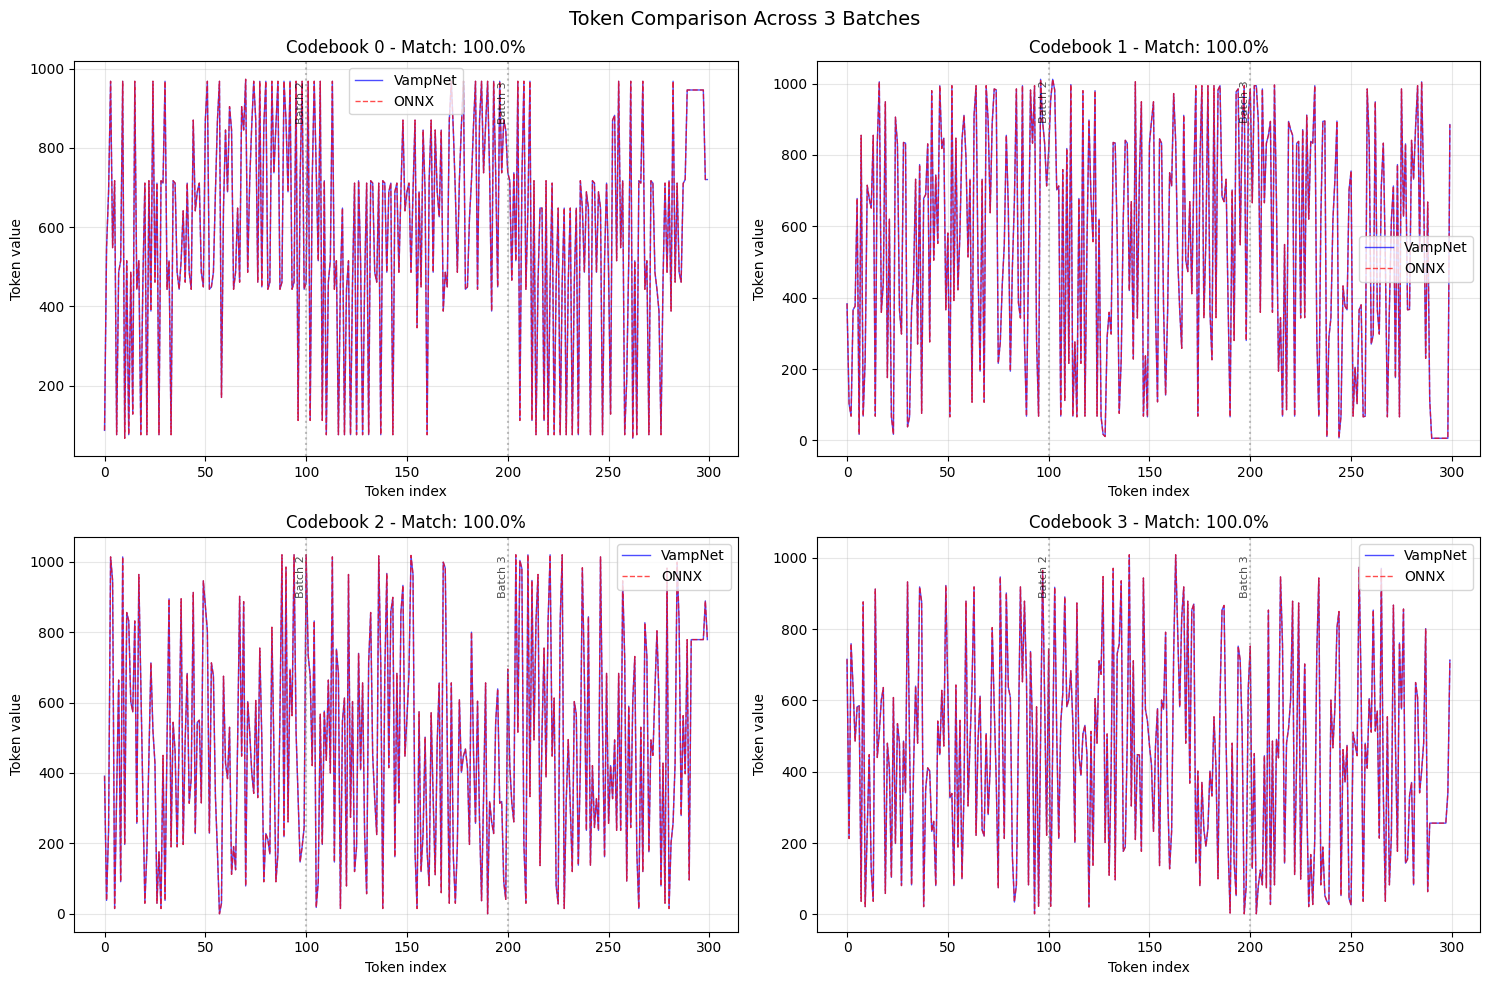

In [7]:
# Visualize tokens around batch boundaries
batch_size = 100
n_batches = min_length // batch_size

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for cb_idx in range(min(4, vampnet_codes.shape[1])):
    ax = axes[cb_idx]
    
    # Get tokens for this codebook
    vampnet_cb = vampnet_codes_trim[0, cb_idx].cpu().numpy()
    onnx_cb = onnx_codes_trim[0, cb_idx].cpu().numpy()
    
    # Plot
    x = np.arange(len(vampnet_cb))
    ax.plot(x, vampnet_cb, 'b-', label='VampNet', alpha=0.7, linewidth=1)
    ax.plot(x, onnx_cb, 'r--', label='ONNX', alpha=0.7, linewidth=1)
    
    # Mark batch boundaries
    for i in range(1, n_batches):
        boundary = i * batch_size
        ax.axvline(x=boundary, color='gray', linestyle=':', alpha=0.5)
        ax.text(boundary, ax.get_ylim()[1]*0.95, f'Batch {i+1}', 
                rotation=90, va='top', ha='right', fontsize=8, alpha=0.7)
    
    # Highlight differences
    diff_mask = vampnet_cb != onnx_cb
    if diff_mask.any():
        diff_indices = np.where(diff_mask)[0]
        ax.scatter(diff_indices, vampnet_cb[diff_indices], 
                  color='yellow', s=20, marker='o', 
                  edgecolor='black', linewidth=0.5, label='Differences', zorder=5)
    
    ax.set_title(f'Codebook {cb_idx} - Match: {match_rate_per_codebook[cb_idx]:.1%}')
    ax.set_xlabel('Token index')
    ax.set_ylabel('Token value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Token Comparison Across {n_batches} Batches', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Analyze Batch-wise Performance

Batch 1: 100.0% match rate
Batch 2: 100.0% match rate
Batch 3: 100.0% match rate


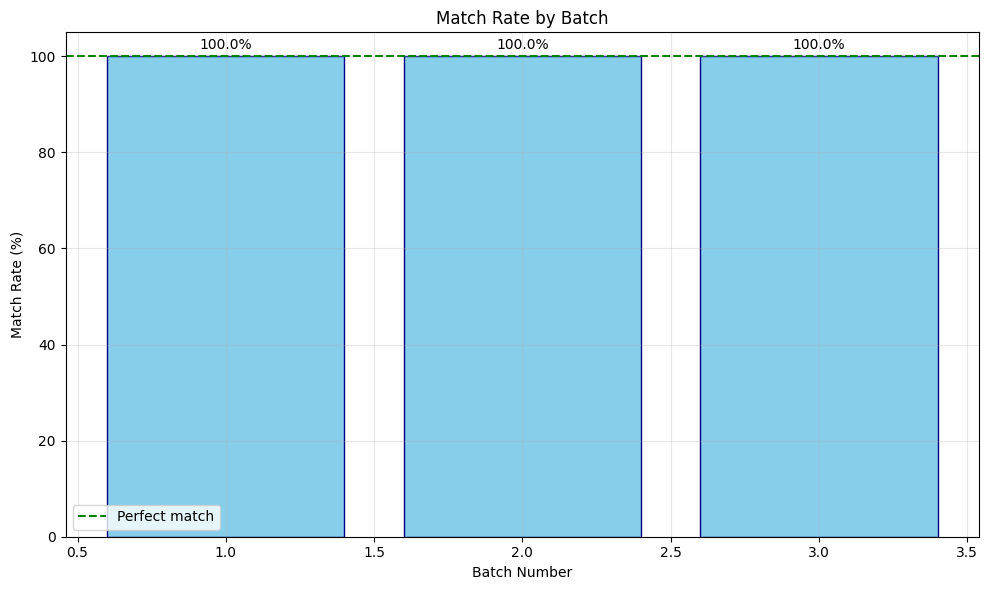

In [8]:
# Analyze match rate per batch
batch_match_rates = []

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, min_length)
    
    batch_matches = matches[:, :, start_idx:end_idx]
    batch_match_rate = batch_matches.mean().item()
    batch_match_rates.append(batch_match_rate)
    
    print(f"Batch {batch_idx + 1}: {batch_match_rate:.1%} match rate")

# Plot batch match rates
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(batch_match_rates) + 1), 
        [r * 100 for r in batch_match_rates],
        color='skyblue', edgecolor='navy')
plt.axhline(y=100, color='green', linestyle='--', label='Perfect match')
plt.xlabel('Batch Number')
plt.ylabel('Match Rate (%)')
plt.title('Match Rate by Batch')
plt.ylim(0, 105)
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels on bars
for i, rate in enumerate(batch_match_rates):
    plt.text(i + 1, rate * 100 + 1, f'{rate*100:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Test Reconstruction

High match rate detected. Testing reconstruction...
Original audio: (220500,)
Reconstructed audio: (220416,)

Reconstruction metrics:
  MSE: 0.005347
  SNR: 11.4 dB


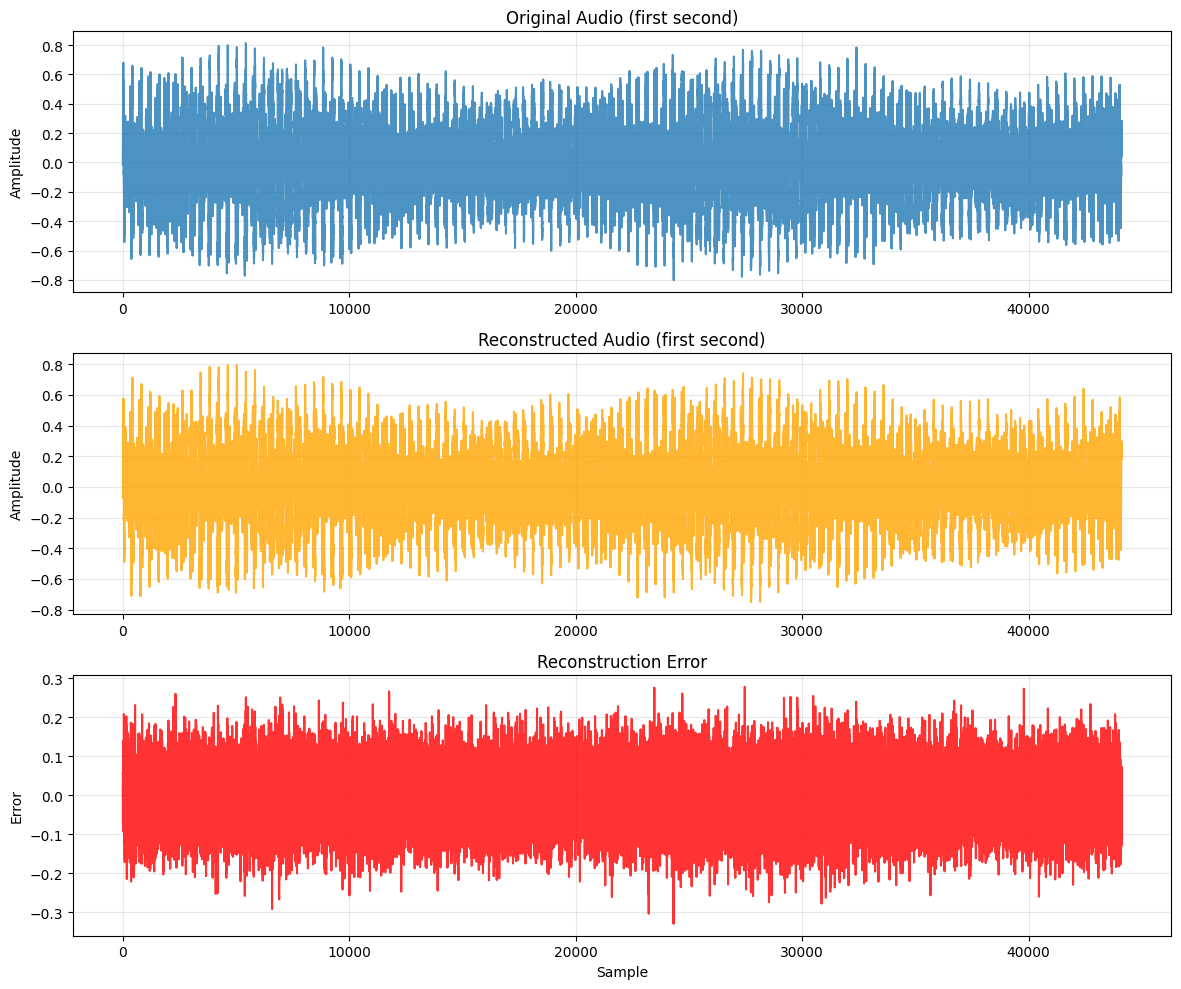


Audio files saved to outputs/batched_comparison


In [9]:
# If match rate is high, test reconstruction
if overall_match_rate > 0.9:
    print("High match rate detected. Testing reconstruction...")
    
    # Decode with VampNet
    with torch.no_grad():
        # Trim to actual audio length (remove padding from last batch)
        n_original_samples = len(audio)
        n_original_tokens = n_original_samples // 768
        
        # Use VampNet codes for reconstruction
        codes_for_decode = vampnet_codes[:, :, :n_original_tokens]
        
        # Decode
        audio_dict = interface.decode(codes_for_decode)
        reconstructed = audio_dict.audio_data.squeeze().cpu().numpy()
    
    print(f"Original audio: {audio.shape}")
    print(f"Reconstructed audio: {reconstructed.shape}")
    
    # Trim to same length for comparison
    min_len = min(len(audio), len(reconstructed))
    
    # Calculate reconstruction metrics
    mse = np.mean((audio[:min_len] - reconstructed[:min_len])**2)
    snr = 10 * np.log10(np.mean(audio[:min_len]**2) / mse) if mse > 0 else float('inf')
    
    print(f"\nReconstruction metrics:")
    print(f"  MSE: {mse:.6f}")
    print(f"  SNR: {snr:.1f} dB")
    
    # Plot comparison
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Original
    axes[0].plot(audio[:44100], label='Original', alpha=0.8)
    axes[0].set_title('Original Audio (first second)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Reconstructed
    axes[1].plot(reconstructed[:44100], label='Reconstructed', color='orange', alpha=0.8)
    axes[1].set_title('Reconstructed Audio (first second)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    # Difference
    diff = audio[:44100] - reconstructed[:44100]
    axes[2].plot(diff, label='Difference', color='red', alpha=0.8)
    axes[2].set_title('Reconstruction Error')
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel('Error')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save audio files
    output_dir = Path("outputs/batched_comparison")
    output_dir.mkdir(exist_ok=True, parents=True)
    
    sf.write(output_dir / "original.wav", audio, sr)
    sf.write(output_dir / "reconstructed.wav", reconstructed[:len(audio)], sr)
    print(f"\nAudio files saved to {output_dir}")
    
else:
    print(f"Match rate too low ({overall_match_rate:.1%}) for meaningful reconstruction.")

## Summary

In [10]:
print("\n" + "=" * 70)
print("BATCHED ENCODING COMPARISON SUMMARY")
print("=" * 70)
print(f"\nAudio duration: {len(audio)/sr:.2f} seconds")
print(f"Total samples: {len(audio)}")
print(f"Batch size: 100 tokens (76,800 samples)")
print(f"Number of batches: {len(batches)}")
print(f"\nVampNet total tokens: {vampnet_codes.shape[2]}")
print(f"ONNX total tokens: {onnx_codes.shape[2]}")
print(f"\nOverall match rate: {overall_match_rate:.1%}")

if overall_match_rate > 0.95:
    print("\n✅ EXCELLENT MATCH! The batched encoding approach works perfectly.")
    print("   The ONNX encoder produces identical results to VampNet when")
    print("   processing audio in 100-token batches.")
elif overall_match_rate > 0.9:
    print("\n⚠️  Good match with minor differences.")
else:
    print("\n❌ Significant differences detected.")
    print("   This suggests issues beyond the sequence length limitation.")

print("\nPer-batch analysis:")
for i, rate in enumerate(batch_match_rates):
    status = "✅" if rate > 0.95 else "⚠️" if rate > 0.9 else "❌"
    print(f"  Batch {i+1}: {rate:.1%} {status}")

print("\n" + "=" * 70)


BATCHED ENCODING COMPARISON SUMMARY

Audio duration: 5.00 seconds
Total samples: 220500
Batch size: 100 tokens (76,800 samples)
Number of batches: 3

VampNet total tokens: 300
ONNX total tokens: 300

Overall match rate: 100.0%

✅ EXCELLENT MATCH! The batched encoding approach works perfectly.
   The ONNX encoder produces identical results to VampNet when
   processing audio in 100-token batches.

Per-batch analysis:
  Batch 1: 100.0% ✅
  Batch 2: 100.0% ✅
  Batch 3: 100.0% ✅

